In [49]:
import math
import torch
import torch.nn as nn
import hess
from hess.nets import MaskedNet
from torch.nn import Module, init
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import numpy as np
from hess import utils
import matplotlib.pyplot as plt

In [2]:
class MaskedLayer(Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True, pct_keep=0.6):
        super(MaskedLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
        dist = torch.distributions.Bernoulli(pct_keep)
        self.mask = dist.sample(sample_shape=torch.Size(self.weight.shape))
        
        if bias:
            self.bias_mask = dist.sample(sample_shape=torch.Size(self.bias.shape))

        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)


    def forward(self, input):
        return F.linear(input, self.weight * self.mask, self.bias * self.bias_mask)
    
    def extra_repr(self):
        return 'iln_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [3]:
in_ = 10
hid_ = 5
module = nn.ModuleList()
layer = MaskedLayer(in_, hid_, pct_keep=0.6)
module.append(layer)
mod = torch.nn.Sequential(*module)

In [4]:
inp = torch.rand(1, 10)

In [5]:
layer(inp)

tensor([[ 0.2155, -0.7685, -0.3858, -0.0486,  0.3608]],
       grad_fn=<AddmmBackward>)

In [6]:
mod(inp)

tensor([[ 0.2155, -0.7685, -0.3858, -0.0486,  0.3608]],
       grad_fn=<AddmmBackward>)

## Now actually trying to build masked nets ##

In [7]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [8]:
X, Y = twospirals(500, noise=1.3)
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [9]:
model = hess.nets.MaskedNet(train_x, train_y, bias=True)

In [11]:
loss_func=nn.MSELoss()
optim=torch.optim.Adam
lr=0.01
iters=1000

optimizer=optim(model.parameters(), lr=lr)


optimizer.zero_grad()
outputs = model(train_x)

loss=loss_func(outputs,train_y)

In [12]:
loss.backward()

## Compute Hessian

In [14]:
print([p.grad for p in ddmodel.parameters()])

[tensor([[ 0.1249,  0.1545],
        [-0.0019, -0.0709],
        [ 0.0081, -0.0053],
        [ 0.0000,  0.0000],
        [-0.1368, -0.1205],
        [ 0.0000, -0.0110],
        [ 0.0000, -0.0891],
        [-0.0638,  0.0000],
        [-0.0036,  0.0018],
        [-0.0093,  0.0000]]), tensor([-0.0306,  0.0099,  0.0000,  0.0000,  0.0247, -0.0026, -0.0000, -0.0110,
         0.0004, -0.0000]), tensor([[ 0.0000e+00,  1.5796e-01,  0.0000e+00,  0.0000e+00,  2.8171e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5288e-02,  8.6534e-02],
        [-2.5929e-01, -5.6466e-01, -1.0089e-01,  0.0000e+00, -1.0070e+00,
         -0.0000e+00, -1.1470e-01, -0.0000e+00, -3.4061e-01, -3.0932e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.8

In [41]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [46]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par).unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model.parameters(),
                            net=model,
                            criterion=torch.nn.BCEWithLogitsLoss(),
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(model, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    
#     print(pp)
    hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()

In [34]:
torch.nn.ReLU()

ReLU()

In [65]:
def get_mask(net):
    mask_list = []
    for lyr in net.sequential:
        if isinstance(lyr, hess.nets.MaskedLayer):
            mask_list.append(lyr.mask)
            
    return hess.utils.flatten(mask_list)

In [66]:
get_mask(model)

tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 0., 0., 1.])

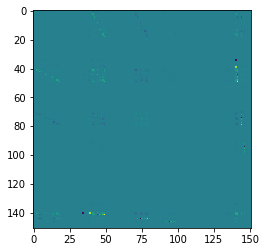

In [50]:
plt.imshow(hessian)

In [ ]:
utils.flatten()